### Lab 1.4 AI Hardware and GPUs
### Mandelbrot CPU
This notebook shows you how to generate Mandelbrot using the CPU and in the second code blocks uses PyCuda to generate a Mandelbrot using the GPU.  


It took 120.47311854362488 seconds to calculate the Mandelbrot graph.
It took 0.29725170135498047 seconds to dump the image.


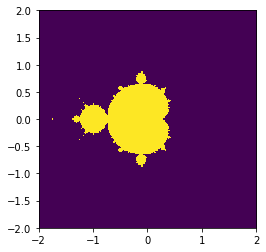

In [7]:
#cpu
from time import time
%matplotlib inline
#import matplotlib
#this will prevent the figure from popping up
#matplotlib.use('Agg')

from matplotlib import pyplot as plt
import numpy as np

def simple_mandelbrot(width, height, real_low, real_high, imag_low, imag_high, max_iters, upper_bound):
    
    real_vals = np.linspace(real_low, real_high, width)
    imag_vals = np.linspace(imag_low, imag_high, height)
        
    # we will represent members as 1, non-members as 0.
    
    mandelbrot_graph = np.ones((height,width), dtype=np.float32)
    
    for x in range(width):
        
        for y in range(height):
            
            c = np.complex64( real_vals[x] + imag_vals[y] * 1j  )            
            z = np.complex64(0)
            
            for i in range(max_iters):
                
                z = z**2 + c
                
                if(np.abs(z) > upper_bound):
                    mandelbrot_graph[y,x] = 0
                    break
                
    return mandelbrot_graph


if __name__ == '__main__':
    
    t1 = time()
    mandel = simple_mandelbrot(512,512,-2,2,-2,2,256, 2.5)
    t2 = time()
    mandel_time = t2 - t1
    
    t1 = time()
    fig = plt.figure(1)
    plt.imshow(mandel, extent=(-2, 2, -2, 2))
    plt.savefig('mandelbrot.png', dpi=fig.dpi)
    t2 = time()
    
    dump_time = t2 - t1
    
    print('It took {} seconds to calculate the Mandelbrot graph.'.format(mandel_time))
    print('It took {} seconds to dump the image.'.format(dump_time))


### Mandlebrot GPU PyCuda
#if you get an error regarding the fatbinaryloader.so file, you can run the command below to see if it exists and confirm the version. 
#errors can be related to a mismatch between the nvidia jetson image and the container version. Check your version
#you can either reinstall a newer image or downgrade to an earlier container version
!find / -iname libnvidia-fatbinaryloader.so.*
#/var/lib/docker/overlay2/.../diff/<b>usr/lib/aarch64-linux-gnu/libnvidia-fatbinaryloader.so.32.2.0</b>

If you do not have pycuda install, run the following command either in a code block or remove the exclamation and run in the container terminal:
     !pip3 install pycuda

It took 0.427534818649292 seconds to calculate the Mandelbrot graph.
It took 0.1109006404876709 seconds to dump the image.


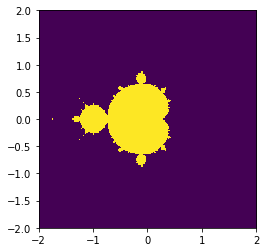

In [6]:
#pycuda
import pycuda.driver 
import pycuda.autoinit
from pycuda.compiler import SourceModule
from pycuda import gpuarray # 4
from pycuda.elementwise import ElementwiseKernel # 5

mandel_ker = ElementwiseKernel(
"pycuda::complex<float> *lattice, float *mandelbrot_graph, int max_iters, float upper_bound",
"""
mandelbrot_graph[i] = 1;

pycuda::complex<float> c = lattice[i]; 
pycuda::complex<float> z(0,0);

for (int j = 0; j < max_iters; j++)
    {
    
     z = z*z + c;
     
     if(abs(z) > upper_bound)
         {
          mandelbrot_graph[i] = 0;
          break;
         }

    }
         
""",
"mandel_ker")

def gpu_mandelbrot(width, height, real_low, real_high, imag_low, imag_high, max_iters, upper_bound):

    # we set up our complex lattice as such
    real_vals = np.matrix(np.linspace(real_low, real_high, width), dtype=np.complex64) # 1
    imag_vals = np.matrix(np.linspace( imag_high, imag_low, height), dtype=np.complex64) * 1j
    mandelbrot_lattice = np.array(real_vals + imag_vals.transpose(), dtype=np.complex64) # 2 
    
    # copy complex lattice to the GPU
    mandelbrot_lattice_gpu = gpuarray.to_gpu(mandelbrot_lattice) # 3

    # allocate an empty array on the GPU
    mandelbrot_graph_gpu = gpuarray.empty(shape=mandelbrot_lattice.shape, dtype=np.float32) # 4

    mandel_ker( mandelbrot_lattice_gpu, mandelbrot_graph_gpu, np.int32(max_iters), np.float32(upper_bound)) # 5
              
    mandelbrot_graph = mandelbrot_graph_gpu.get() # 6
    
    return mandelbrot_graph

t1 = time()
mandel = gpu_mandelbrot(512,512,-2,2,-2,2,512, 2)
t2 = time()

mandel_time = t2 - t1

t1 = time()
fig = plt.figure(1)
plt.imshow(mandel, extent=(-2, 2, -2, 2))
#plt.savefig('mandelbrot.png', dpi=fig.dpi)
t2 = time()

dump_time = t2 - t1

print ('It took {} seconds to calculate the Mandelbrot graph.'.format(mandel_time))
print ('It took {} seconds to dump the image.'.format(dump_time))

#note the significant reduction in execution time